# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\hashe\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\hashe\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
cor_surv = correlations[survey_fields]
print(cor_surv)

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_10           NaN
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


C:\Users\hashe\Anaconda3\lib\site-packages\pandas\core\series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


# Plotting the Correlation of Sat Score vs Survey Data

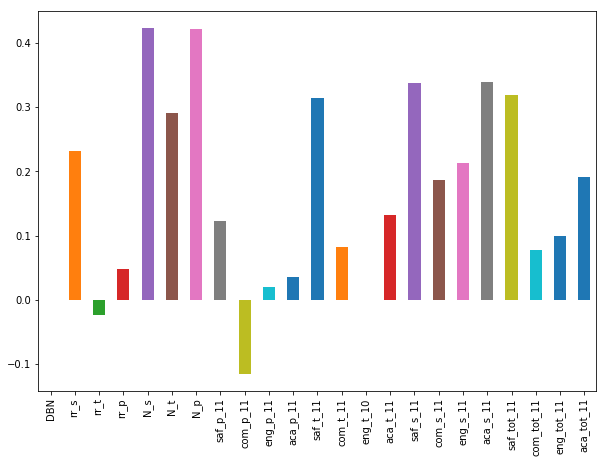

In [13]:
cor_surv.plot.bar(figsize=(10,7))

From the data we see a fairly strong positive correlation between N_s, N_t, N_p (Number of student, teacher and parent respondents of the survey) and the Sat score. This makes sense as these parameters are directly related to Total enrollment, a relationship we have established earlier
It is also interesting to see rr_s, the student response rate, or the percentage of students who completed the survey, has a positive correlation with sat score which makes sense as students who are willing to spend time filling such surveys are more likely to perform well academically.
How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring Safety

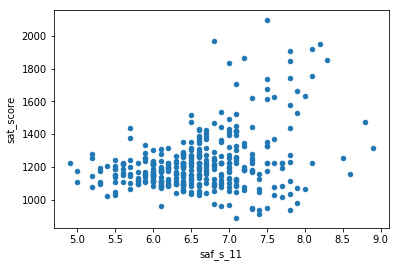

In [14]:
combined.plot.scatter('saf_s_11', 'sat_score')

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [15]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

# Mapping Safety Scores

In [17]:
pip install mpl_toolkits


The following command must be run outside of the IPython shell:

    $ pip install mpl_toolkits

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
m = Basemap( 
projection = 'merc',
llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, latlon = True,zorder =2, s = 50, c= districts['saf_s_11'], cmap='summer')
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

From the scatter plot above we see that the Bronx, Upper Manhattan and some parts of the Queens have lower safety scores. Brooklyn seems to be a safe area according to the data.

 # Racial differences in SAT scores

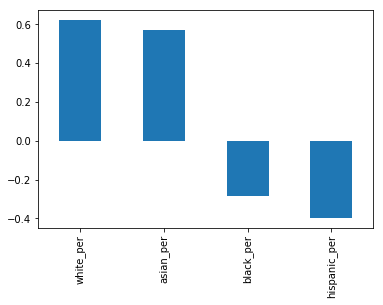

In [17]:
cors = combined.corr()['sat_score'][['white_per', 'asian_per', 'black_per', 'hispanic_per']]
cors.plot.bar()

The graph clearly shows that there is a positive correlation between the sat scores of white and asian students whereas there is a negative correlation between the sat scores of black and hispanic students.

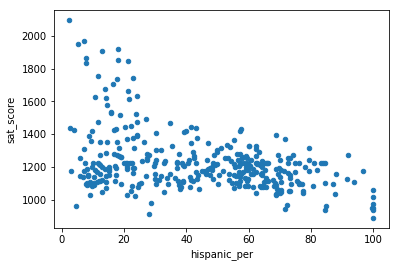

In [18]:
combined.plot.scatter('hispanic_per', 'sat_score')

The scatter plots show that schools with higher percentage of hispanic students tend to perform worse in the SAT

In [19]:
combined[combined['hispanic_per'] > 95][['SchoolName','hispanic_per']]

,SchoolName,hispanic_per
44,Manhattan Bridges High School,99.8
82,0,96.7
89,GREGORIO LUPERON HS SCI & MATH,99.8
125,Academy for Language and Technology,99.4
141,International School for Liberal Arts,99.8
176,0,99.8
253,Multicultural High School,99.8
286,0,100.0


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores

In [20]:
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800) ]['SchoolName']

37                           STUYVESANT HS
151                    BRONX HS OF SCIENCE
187                  BROOKLYN TECHNICAL HS
327    Queens HS for Science York Colllege
356             STATEN ISLAND TECHNICAL HS
Name: SchoolName, dtype: object

The schools shown above have average SAT scores greater than 1800. They seem to be technical schools which recieve higher funding which seems to explain the difference in scores

# Gender Differences in SAT

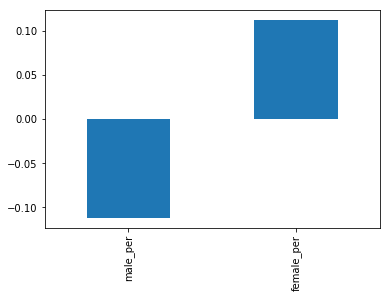

In [21]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

There seems to be a positive correlation between the female percentage of the school and its SAT score whereas a negative correlation is seen when the percentage of a school is male dominated. None of these correlations seem very strong.

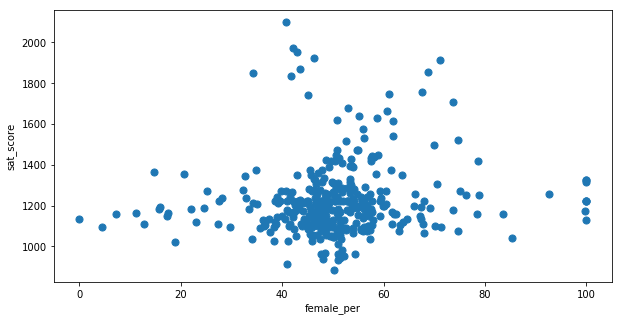

In [22]:
combined.plot.scatter('female_per', 'sat_score', figsize=(10,5), s=50)

An interesting pattern is seen here. The schools with an equal proportion of boy and girls seem to do better than the others. There is also a cluster of schools that seemed to do well with a female percentage lying between 60 to 80.

In [23]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SchoolName']

5                                  0
26     Eleanor Roosevelt High School
60                     BEACON SCHOOL
61           FIORELLO H.LAGUARDIA HS
302               TOWNSEND HARRIS HS
Name: SchoolName, dtype: object

These schools appear to be very selective schools

# AP Test Scores vs SAT Scores


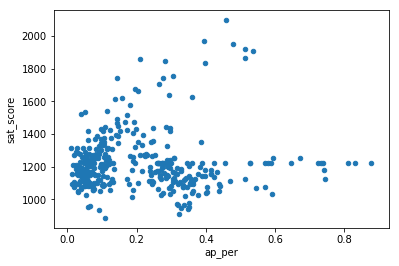

In [24]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter('ap_per', 'sat_score')


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.